# Multi-Path Effect with Raytracing

This is an example of using `RadarSimPy` to simulate an FMCW radar with a corner reflector model above the ground surface. Ray-Tracing/Shoot-and-Bounce-Rays method is used in `RadarSimPy`. The ray-tracing engine `RadarSimC`, which is built with C++, is integrated in RadarSimPy.

>`RadarSimPy` is a radar simulation package built with python. **<a href="https://zpeng.me/#contact" target="_blank">Contact me</a> if you are interested in this module.**

This notebook is available on my <a href="https://github.com/rookiepeng/radar-simulation-notebooks" target="_blank">GitHub</a>.

---

## Setup FMCW radar

### Transmitter

The following table lists the basic parameters of the radar transmitter.

 | Parameter                       | Variable in `RadarSimPy` | Value      |
 |---------------------------------|--------------------------|------------|
 | Center frequency ($f_c$)        | fc                       | 77 GHz     |
 | Bandwidth ($B$)                 | bandwidth                | 100 MHz    |
 | Transmitted power ($P_t$)       | tx_power                 | 15 dBm     |
 | Chirp repetition period ($CRP$) | repetition_period        | 100 us     |
 | Chirp length ($T$)              | pulse_length             | 40 us      |
 | Number of chirps                | pulses                   | 1          |
 | Chirp start delay               | delay                    | 0 s        |
 
### Receiver
 The parameters of the receiver are listed in the table below.

 | Parameter                        | Variable in `RadarSimPy` | Value        |
 |----------------------------------|--------------------------|--------------|
 | Sampling rate ($f_s$)            | fs                       | 4 Msps       |
 | Noise figure ($NF$)              | noise_figure             | 8 dB         |
 | RF gain/loss ($G_{rf}$)          | rf_gain                  | 20 dB        |
 | Load resistor ($R_L$)            | load_resistor            | 1000 $\Omega$|
 | Baseband voltage gain ($G_{BB}$) | baseband_gain            | 80 dB        |


In [1]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

angle = np.arange(-90, 91, 1)
pattern = 20 * np.log10(np.cos(angle / 180 * np.pi) + 0.01)

tx_channel = dict(
    location=(0, 0, 0),
    azimuth_angle=angle,
    azimuth_pattern=pattern,
    elevation_angle=angle,
    elevation_pattern=pattern,
)

tx = Transmitter(f=[77e9-50e6, 77e9+50e6],
                 t=40e-6,
                 tx_power=15,
                 prp=100e-6,
                 pulses=1,
                 channels=[tx_channel])



rx_channel = dict(
    location=(0, 0, 0),
    azimuth_angle=angle,
    azimuth_pattern=pattern,
    elevation_angle=angle,
    elevation_pattern=pattern,
)

rx = Receiver(fs=4e6,
              noise_figure=8,
              rf_gain=20,
              load_resistor=1000,
              baseband_gain=80,
              channels=[rx_channel])


radar = Radar(transmitter=tx, receiver=rx, time=np.arange(0, 150, 1))

## Case 1: A corner reflector with ground surface

In [2]:
from radarsimpy.rt import scene
from scipy import signal
import radarsimpy.processing as proc

target_1 = {
    'model': '../models/cr.stl',
    'location': (50, 0, 0),
    'speed': (1, 0, 0)
}

target_2 = {
    'model': '../models/surface_400x400.stl',
    'location': (0, 0, -0.5),
    'speed': (0, 0, 0),
    'is_ground': True
}
targets = [target_1, target_2]

data = scene(radar, targets, density=0.5, noise=False)
baseband = data['baseband']

range_window = signal.chebwin(radar.samples_per_pulse, at=60)
range_profile = proc.cal_range_profile(radar, baseband, range_window)

doppler_window = signal.chebwin(radar.transmitter.pulses, at=60)
range_doppler = proc.cal_range_doppler(
    radar, range_profile, doppler_window, fft_shift=False)

amp_multi = np.max(20*np.log10(np.abs(range_profile)), axis=2)

## Case 2: A corner reflector without ground surface

In [3]:
target_1 = {
    'model': '../models/cr.stl',
    'location': (50, 0, 0),
    'speed': (1, 0, 0)
}

targets = [target_1]

data = scene(radar, targets, density=0.5, noise=False)
baseband = data['baseband']
range_window = signal.chebwin(radar.samples_per_pulse, at=60)
range_profile = proc.cal_range_profile(radar, baseband, range_window)

amp_single = np.max(20*np.log10(np.abs(range_profile)), axis=2)

## Results

Duo to the multi-path:
- Path 1: Tx -> Corner reflecor -> Rx
- Path 2: Tx -> Ground -> Corner reflecor -> Ground -> Rx

A fluctuation can be observed from the received target amplitude versus the target range. 

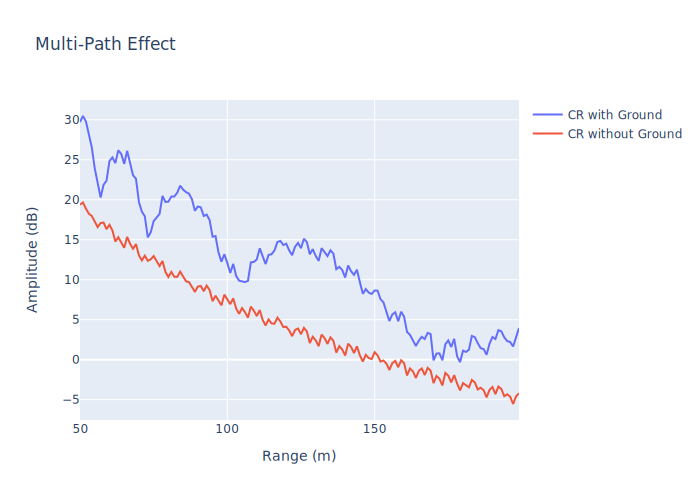

In [4]:
import plotly.graph_objs as go
from plotly.offline import iplot
from IPython.display import SVG, display

t_range = 50+np.arange(0, 150, 1)*1

p_multi = go.Scatter(x=t_range, y=amp_multi[:,0],
                     name='CR with Ground')
p_single = go.Scatter(x=t_range, y=amp_single[:,0],
                      name='CR without Ground')

layout = go.Layout(
    title='Multi-Path Effect',
    yaxis=dict(title='Amplitude (dB)'),
    xaxis=dict(title='Range (m)'),
)
fig = go.Figure(data=[p_multi, p_single], layout=layout)
# iplot(fig)
display(SVG(fig.to_image(format='svg', scale=1)))